In [1]:
import pyBigWig
import pandas as pd
import numpy as np
import deepdish as dd
import os
import pyfaidx
import random
import pickle as pkl
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import json
import dinuc_shuffle_main
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5"
%matplotlib inline

In [2]:
#regions = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/negatives_data/negatives_with_summit.bed"
#regions = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/IMR90/negatives_data/negatives_with_summit.bed"
regions = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/negatives_data/negatives_with_summit.bed"

genome = "/mnt/lab_data2/anusri/chrombpnet/reference/hg38.genome.fa"
model_h5 = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_PE/K562/nautilus_runs_may18/K562_05.13.2022_bias_128_4_1234_0.5_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"
#model_h5 = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/nautilus_runs/K562_02.17.2022_bias_128_4_1234_0.5_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"
#model_h5="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/IMR90/nautilus_runs_apr12/IMR90_04.09.2022_bias_128_4_1234_0.8_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"
#model_h5="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/IMR90/nautilus_runs_apr12/IMR90_04.09.2022_bias_128_4_1234_0.4_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"
#model_h5 ="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/nautilus_runs/GM12878_03.06.2022_bias_128_4_1234_0.8_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"
#model_h5 = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"

In [3]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)


def get_footprint_for_motif(seqs, motif, model, inputlen, batch_size):
    '''
    Returns footprints for a given motif. Motif is inserted in both the actual sequence and reverse complemented version.
    seqs input is already assumed to be one-hot encoded. motif is in sequence format.
    '''
    midpoint=inputlen//2

    w_mot_seqs = seqs.copy()
    w_mot_seqs[:, midpoint-len(motif)//2:midpoint-len(motif)//2+len(motif)] =dinuc_shuffle_main.dna_to_one_hot([motif])

    # midpoint of motif is the midpoint of sequence
    pred_output=model.predict(w_mot_seqs, batch_size=batch_size, verbose=True)
    footprint_for_motif_fwd = softmax(pred_output[0])*(np.exp(pred_output[1])-1)

    # reverse complement the sequence
    w_mot_seqs_revc = w_mot_seqs[:, ::-1, ::-1]
    pred_output_rev=model.predict(w_mot_seqs_revc, batch_size=batch_size, verbose=True)
    footprint_for_motif_rev = softmax(pred_output_rev[0])*(np.exp(pred_output_rev[1])-1)

    # add fwd sequence predictions and reverse sesquence predictions (not we flip the rev predictions)
    counts_for_motif = np.exp(pred_output_rev[1]) - 1 + np.exp(pred_output[1]) - 1
    footprint_for_motif_tot = footprint_for_motif_fwd+footprint_for_motif_rev[:,::-1]
    footprint_for_motif =  footprint_for_motif_tot / footprint_for_motif_tot.sum(axis=1)[:, np.newaxis]

    return footprint_for_motif_tot.mean(0), counts_for_motif.mean(0)

def get_footprint_for_two_motifs(seqs, motifs, model, inputlen, batch_size, spacing):
    '''
    Returns footprints for a given motif. Motif is inserted in both the actual sequence and reverse complemented version.
    seqs input is already assumed to be one-hot encoded. motif is in sequence format.
    '''
    midpoint=inputlen//2

    spacing_per_motif = spacing // 2
    
    w_mot_seqs = seqs.copy()
    
    motif = motifs[0]
    start = midpoint-(len(motif)//2)
    w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    print(motif,start,start+len(motif))
    if spacing > 0:
        spacing_per_motif = spacing 
        motif = motifs[1]
        start = start+len(motifs[0])+spacing_per_motif 
        w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    else:
        spacing_per_motif = spacing 
        motif = motifs[1]
        start = start + spacing_per_motif - len(motif)
        w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    
    print(motif,start,start+len(motif))
    
    # midpoint of motif is the midpoint of sequence
    pred_output=model.predict(w_mot_seqs, batch_size=batch_size, verbose=True)
    footprint_for_motif_fwd = softmax(pred_output[0])*(np.exp(pred_output[1])-1)

    # reverse complement the sequence
    w_mot_seqs_revc = w_mot_seqs[:, ::-1, ::-1]
    pred_output_rev=model.predict(w_mot_seqs_revc, batch_size=batch_size, verbose=True)
    footprint_for_motif_rev = softmax(pred_output_rev[0])*(np.exp(pred_output_rev[1])-1)

    # add fwd sequence predictions and reverse sesquence predictions (not we flip the rev predictions)
    counts_for_motif = np.exp(pred_output_rev[1]) - 1 + np.exp(pred_output[1]) - 1
    footprint_for_motif_tot = footprint_for_motif_fwd+footprint_for_motif_rev[:,::-1]
    footprint_for_motif =  footprint_for_motif_tot / footprint_for_motif_tot.sum(axis=1)[:, np.newaxis]

    return footprint_for_motif_tot.mean(0), counts_for_motif.mean(0)

In [4]:
def get_seq(peaks_df, genome, width, shuffle=False):
    """
    fetches sequence from a given genome.
    """
    vals = []

    for i, r in peaks_df.iterrows():
        sequence = str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)])
        if len(sequence) == width:
                vals.append(sequence)

    return dinuc_shuffle_main.dna_to_one_hot(vals)

In [5]:
model=load_model(model_h5)

In [6]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
inputlen = 2114
regions_df = pd.read_csv(regions, sep='\t', names=NARROWPEAK_SCHEMA)
chroms_to_keep = ["chr1"]
regions_subsample = regions_df[(regions_df["chr"].isin(chroms_to_keep))].sample(1000, random_state=0)
genome_fasta = pyfaidx.Fasta(genome)
regions_seqs = get_seq(regions_subsample, genome_fasta, inputlen)

Monomer

In [8]:
motif =  ""
batch_size=128
full_footprint_1 = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)

8/8 [==============================] - 7s 1s/step


In [9]:

#motifs = ["CAGATAAGG", "CTG"]
#motifs = ["CTG","CAGATAAGG"]
motifs = ["CAGATAAGG","CTG"]

#batch_size=128
#puu_runx_footprint = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
data_in_spacings = []
for spacing in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]:
    puu_runx_footprint = get_footprint_for_two_motifs(regions_seqs, motifs, model, inputlen, batch_size, spacing=-1*spacing)
    data_in_spacings.append(puu_runx_footprint)

CAGATAAGG 1053 1062
CTG 1049 1052
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1048 1051
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1047 1050
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1046 1049
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1045 1048
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1044 1047
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1043 1046
8/8 [==============================] - 8s 1s/step
CAGATAAGG 1053 1062
CTG 1042 1045
8/8 [==============================] - 8s 1s/step
CAGATAAGG 1053 1062
CTG 1041 1044
8/8 [==============================] - 8s 1s/step
CAGATAAGG 1053 1062
CTG 1040 1043
8/8 [==============================] - 8s 1s/step
CAGATAAGG 1053 1062
CTG 1039 1042
8/8 [==============================] - 8s 1s/step
CAGATAAGG 1053 1062
CTG 1038 1041
8/8 [==============================] - 8s 

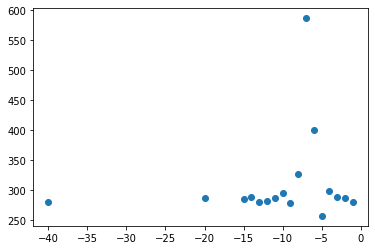

In [10]:

all_counts = [x[1] for x in data_in_spacings]
plt.scatter([-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40],all_counts)

[]

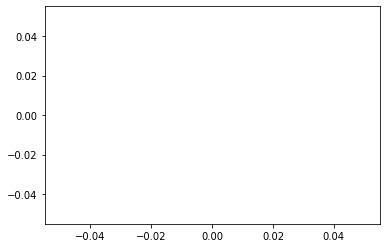

In [11]:
plt.plot()

In [12]:

#motifs = ["CTG","CAGATAAGG"]
motifs = ["CAGATAAGG","CTG"]

#batch_size=128
#puu_runx_footprint = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)
data_in_spacings_rev = []
for spacing in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]:
    puu_runx_footprint = get_footprint_for_two_motifs(regions_seqs, motifs, model, inputlen, batch_size, spacing=spacing)
    data_in_spacings_rev.append(puu_runx_footprint)

CAGATAAGG 1053 1062
CTG 1063 1066
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1064 1067
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1065 1068
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1066 1069
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1067 1070
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1068 1071
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1069 1072
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1070 1073
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1071 1074
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1072 1075
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1073 1076
8/8 [==============================] - 7s 1s/step
CAGATAAGG 1053 1062
CTG 1074 1077
8/8 [==============================] - 7s 

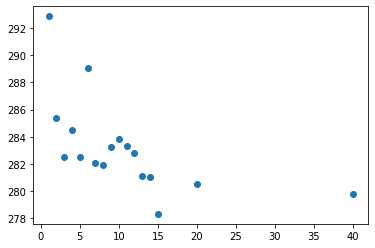

In [13]:
all_counts_rev = [x[1] for x in data_in_spacings_rev]
plt.scatter([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40],all_counts_rev)

In [14]:
full_footprint_1[1]

array([179.79459], dtype=float32)

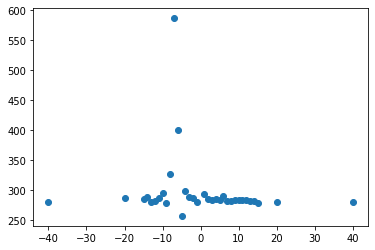

In [15]:
plt.scatter([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40],all_counts_rev+all_counts)


Text(0.5, 0, 'TAL spacing from GATA')

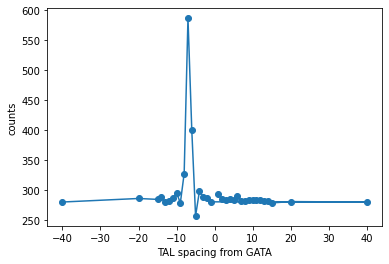

In [16]:
plt.scatter([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40],all_counts_rev[0:]+all_counts[0:])
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40],all_counts_rev[0:]+all_counts[0:])

#plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14],all_counts_rev[0:-3]+all_counts[0:-3],'-o')

from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
 
# Dataset
x = np.array([-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40][::-1]+[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40])
y = np.array(all_counts[::-1]+all_counts_rev)
 
X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
#plt.plot(X_, Y_)
plt.ylabel("counts")
plt.xlabel("TAL spacing from GATA")


 

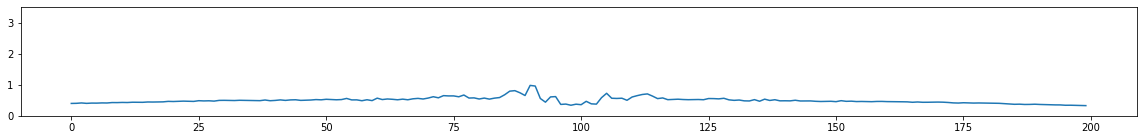

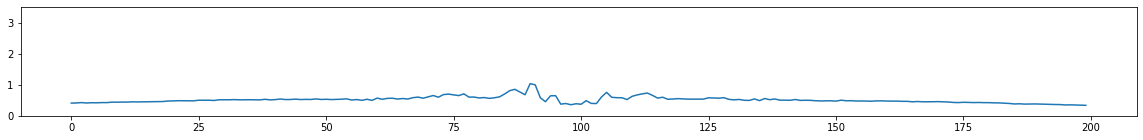

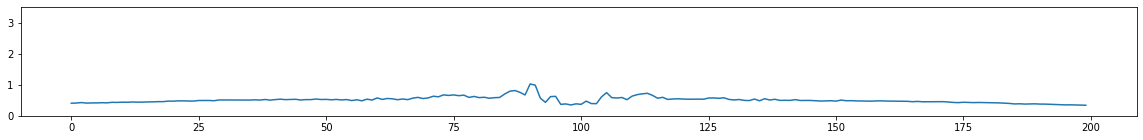

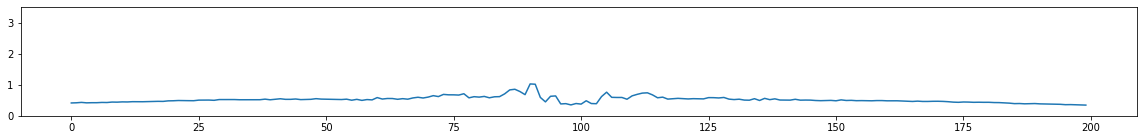

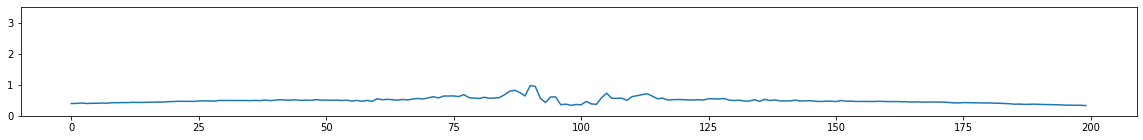

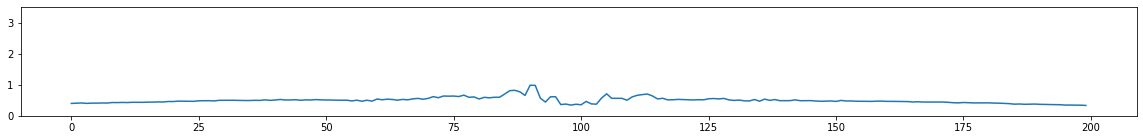

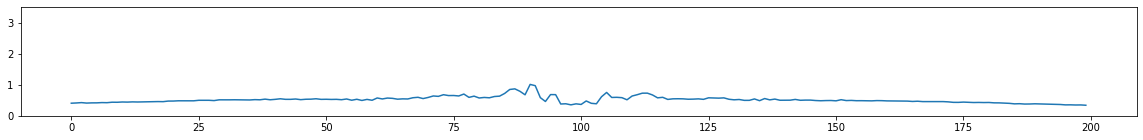

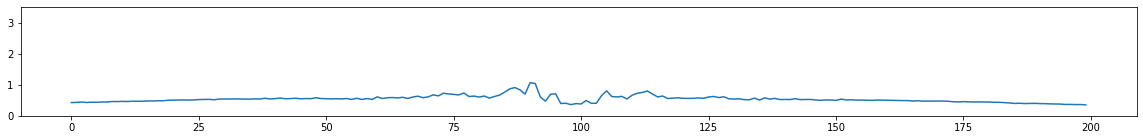

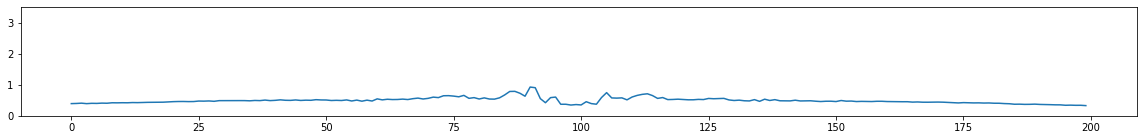

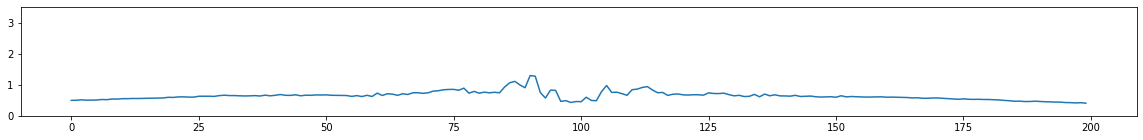

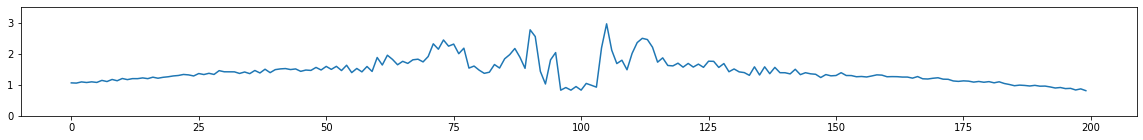

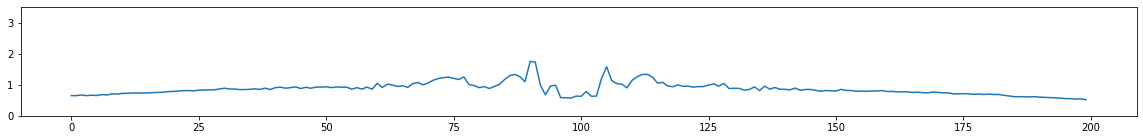

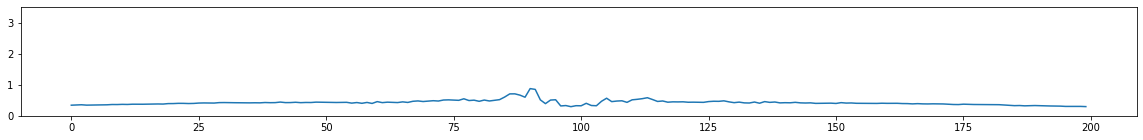

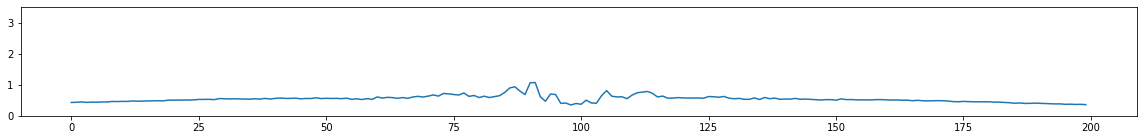

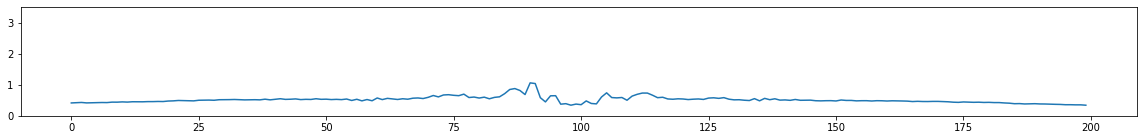

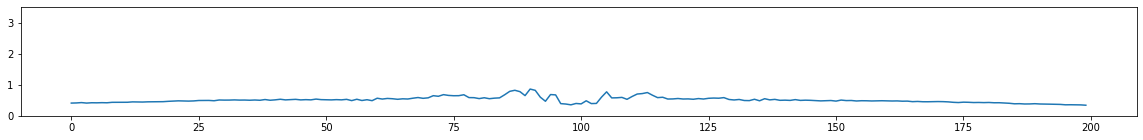

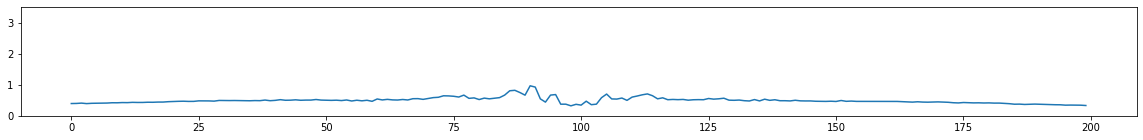

In [22]:
spacings = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40][::-1]
i=0
matplotlib.use('Agg')

for x in  data_in_spacings[::-1]:
    figsize=(20,2)
    fig = plt.figure(figsize=figsize)
    plt.plot(x[0][400:600])
    plt.ylim((0,3.5))
    plt.savefig("images/image_neg_dnase"+str(spacings[i])+".png")
    i = i + 1

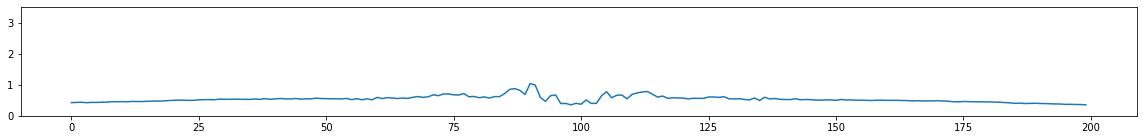

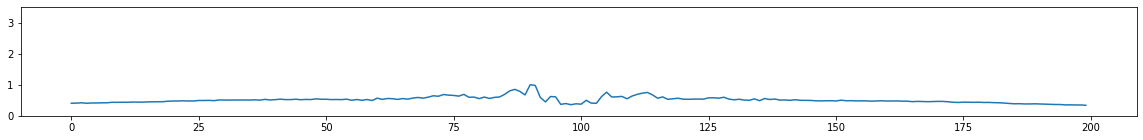

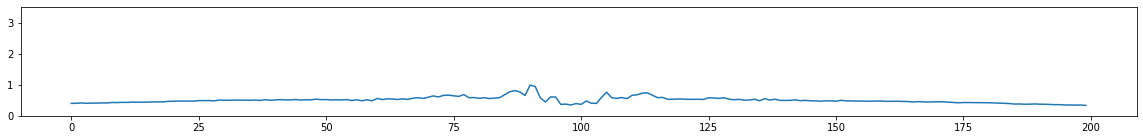

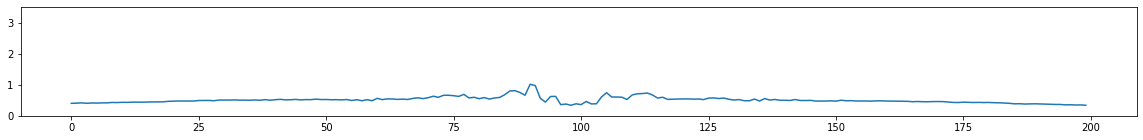

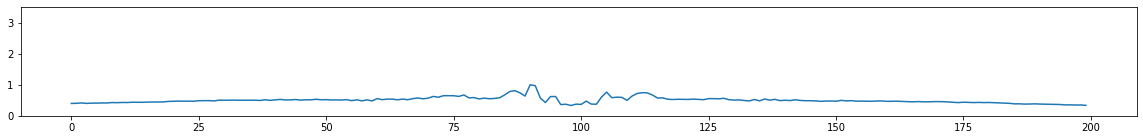

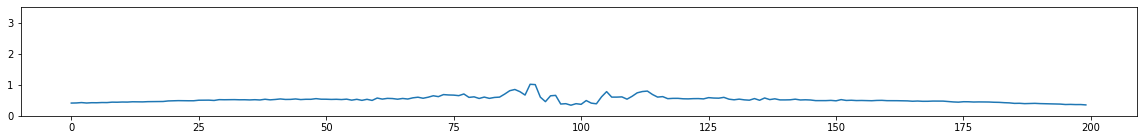

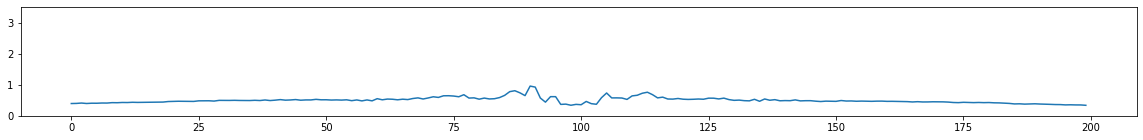

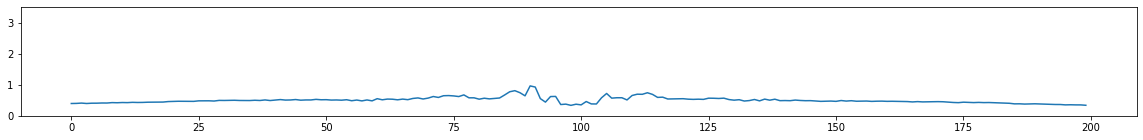

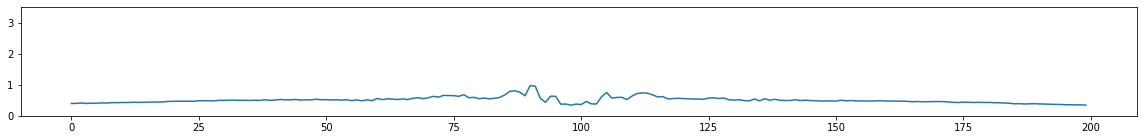

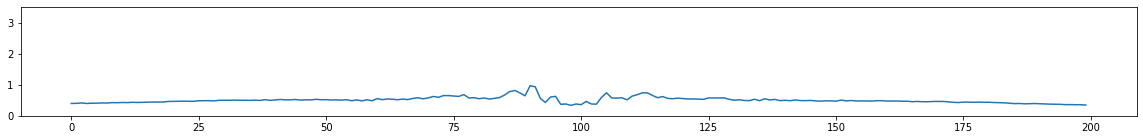

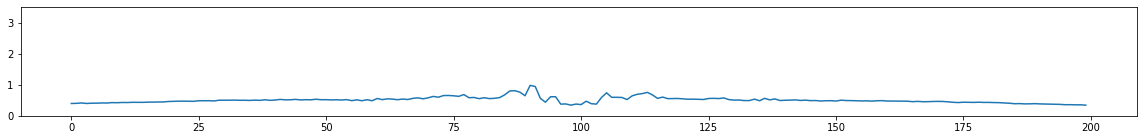

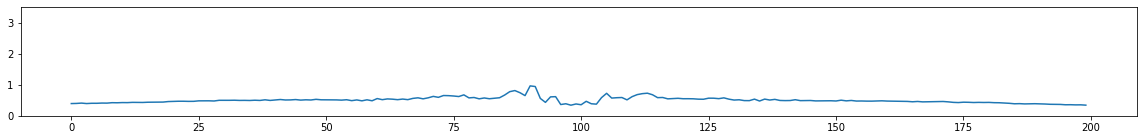

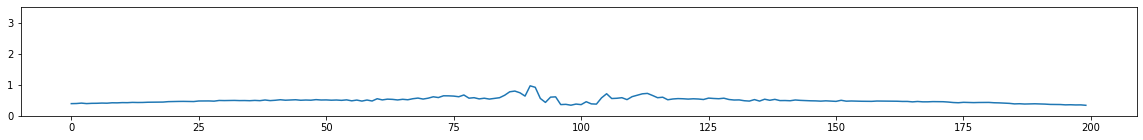

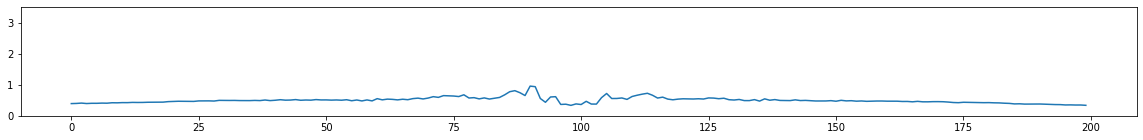

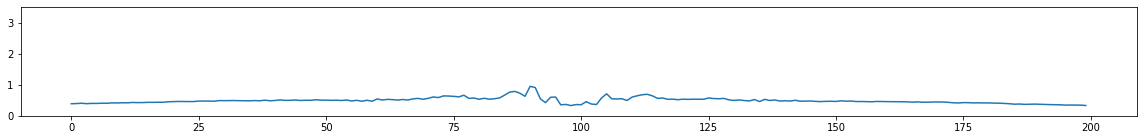

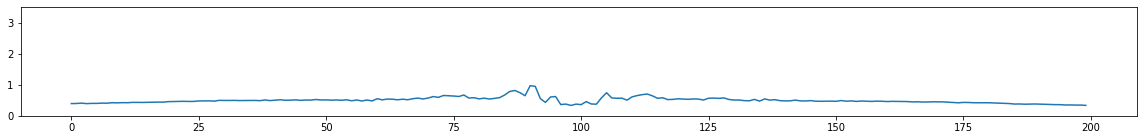

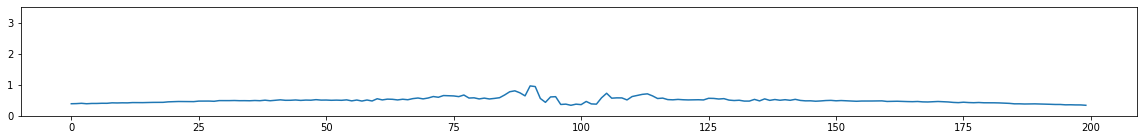

In [18]:
spacings = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]
i=0
matplotlib.use('Agg')

for x in  data_in_spacings_rev:
    figsize=(20,2)
    fig = plt.figure(figsize=figsize)
    plt.plot(x[0][400:600])
    plt.ylim((0,3.5))
    plt.savefig("images/image_pos_dnase"+str(spacings[i])+".png")
    i = i + 1

In [20]:
def get_motifs_images(seqs, motifs, model, inputlen, batch_size, spacing):
    '''
    Returns footprints for a given motif. Motif is inserted in both the actual sequence and reverse complemented version.
    seqs input is already assumed to be one-hot encoded. motif is in sequence format.
    '''
    midpoint=inputlen//2

    spacing_per_motif = spacing // 2
    
    w_mot_seqs = seqs.copy()
    
    motif = motifs[0]
    start = midpoint-(len(motif)//2)
    w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    print(motif,start,start+len(motif))
    if spacing > 0:
        spacing_per_motif = spacing 
        motif = motifs[1]
        start = start+len(motifs[0])+spacing_per_motif 
        w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    else:
        spacing_per_motif = spacing 
        motif = motifs[1]
        start = start + spacing_per_motif - len(motif)
        w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    
    motif = np.sum(w_mot_seqs, axis=0)
    motif = motif/np.sum(motif, axis=-1, keepdims=True)
    bg = np.sum(np.sum(w_mot_seqs, axis=0), axis=0)
    bg = bg/sum(bg)
    return motif, bg
    

CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)


/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)
CAGATAAGG 1053 1062
(2114, 4)


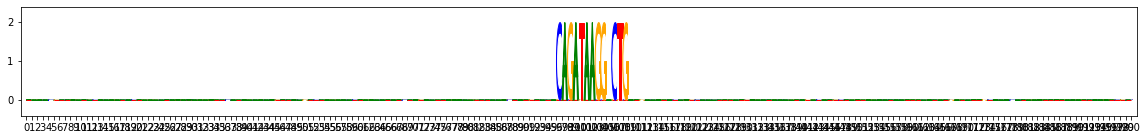

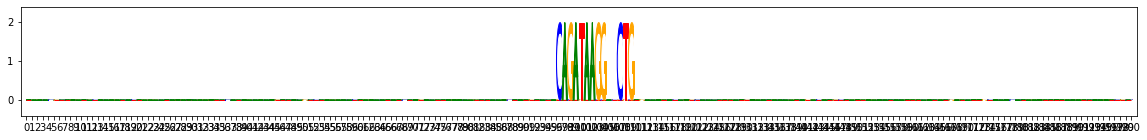

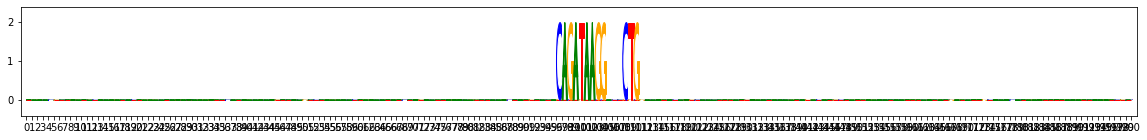

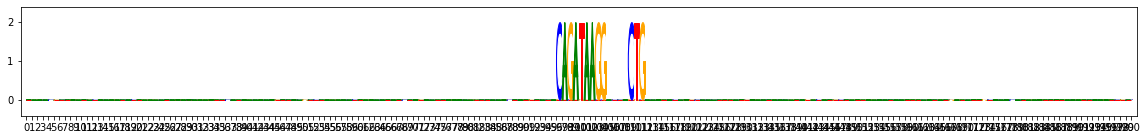

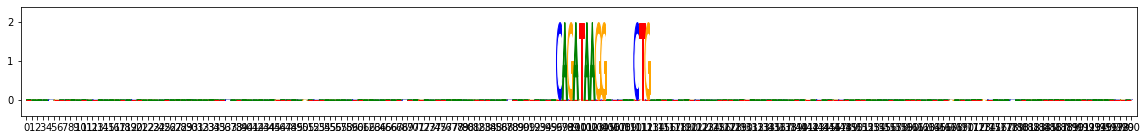

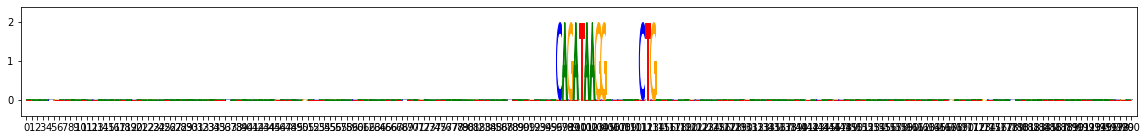

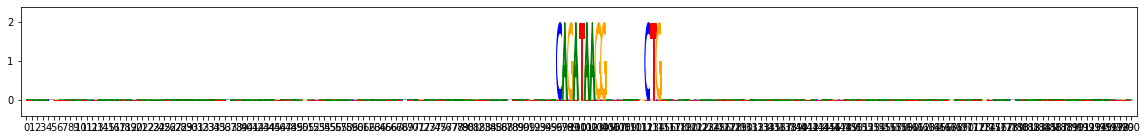

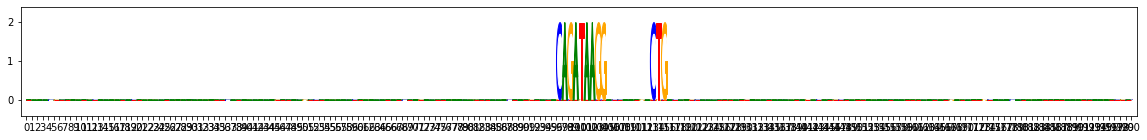

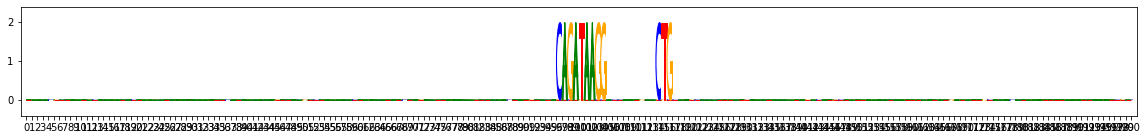

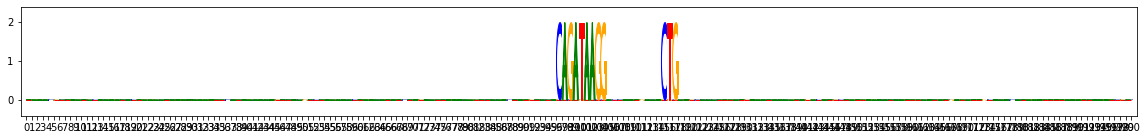

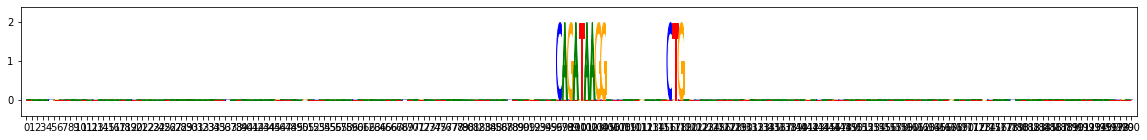

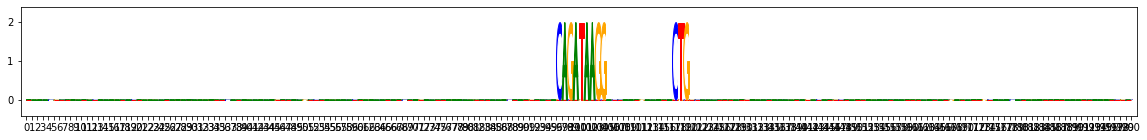

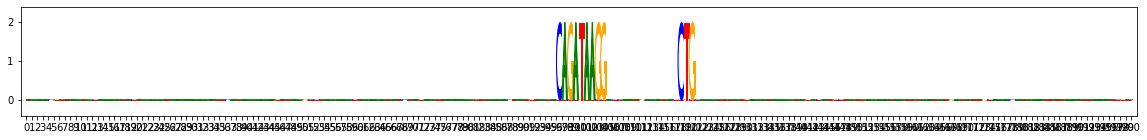

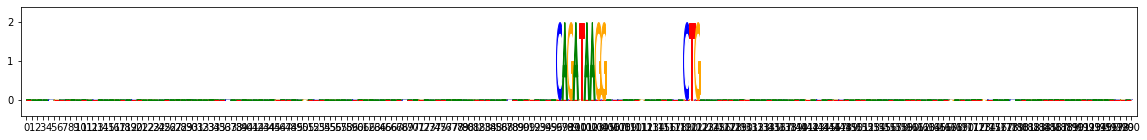

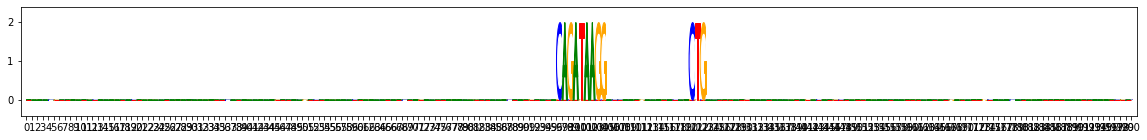

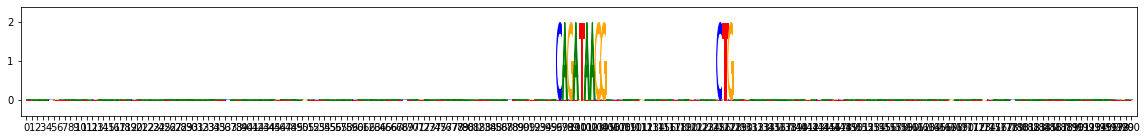

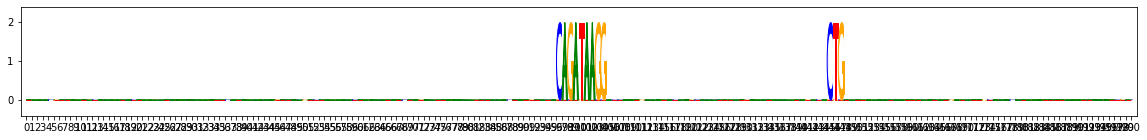

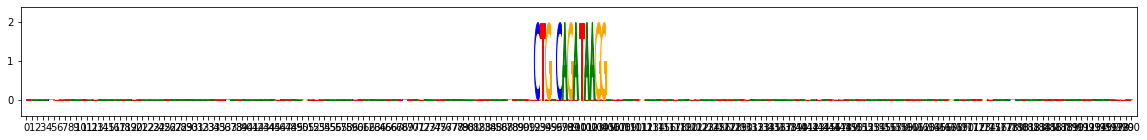

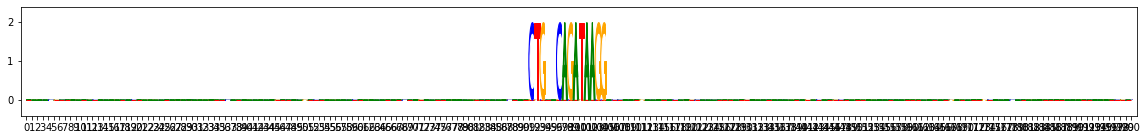

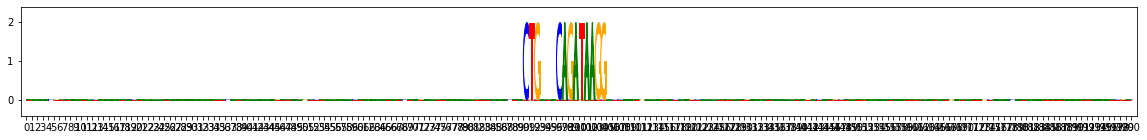

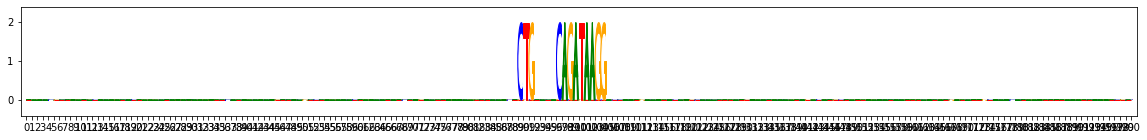

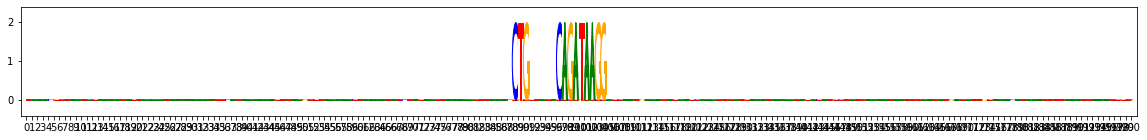

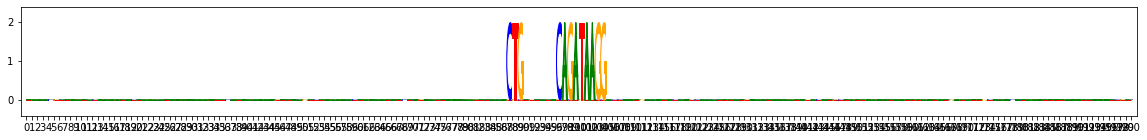

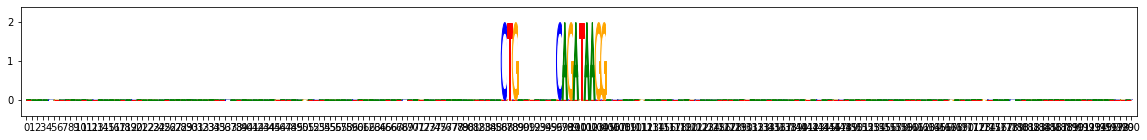

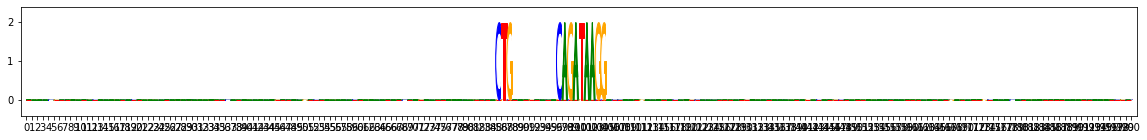

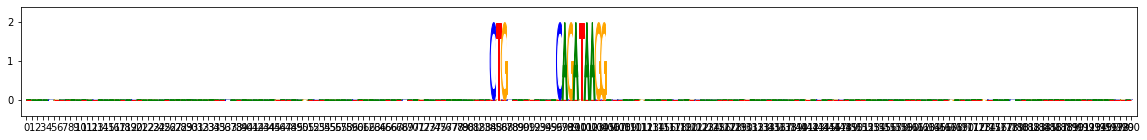

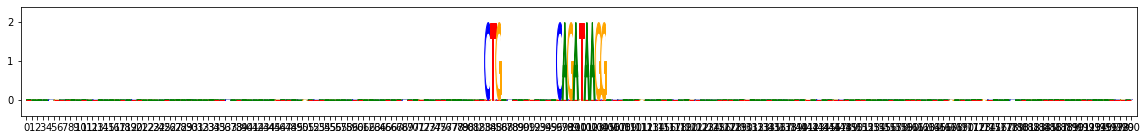

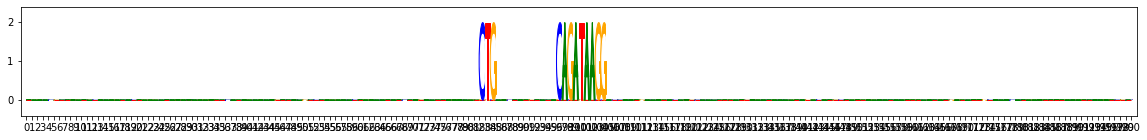

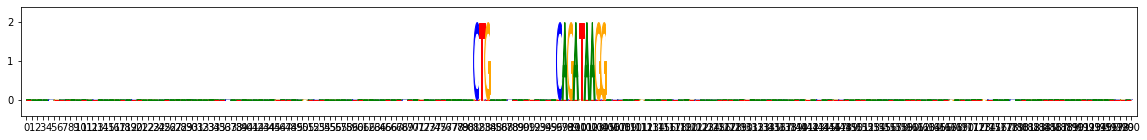

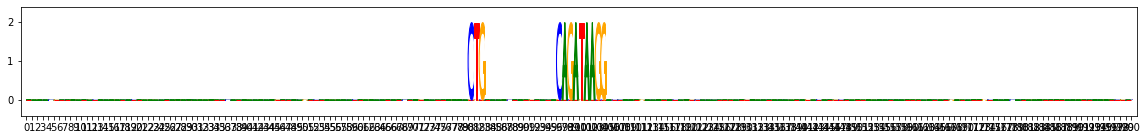

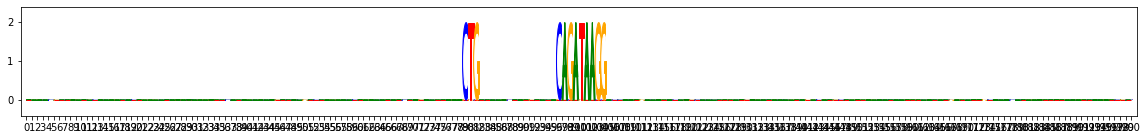

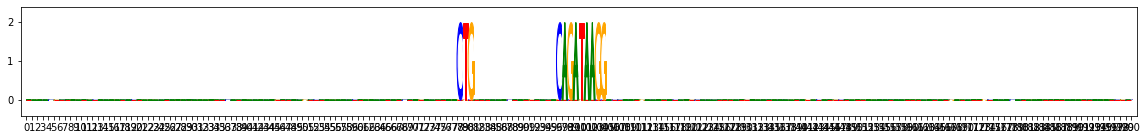

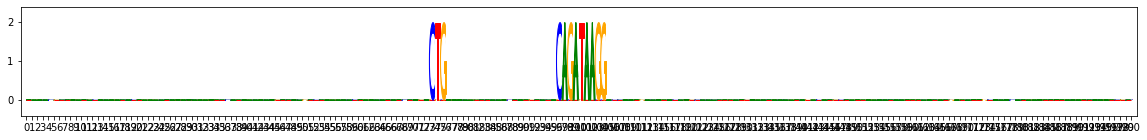

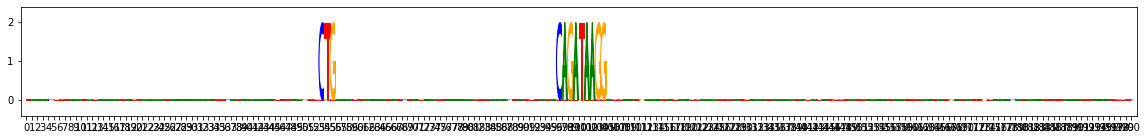

In [21]:
from modisco.visualization import viz_sequence
motifs = ["CAGATAAGG","CTG"]

spacings = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]
i=0
matplotlib.use('Agg')

for x in  spacings:
    motif, bg = get_motifs_images(regions_seqs, motifs, model, inputlen, batch_size, spacing=x)

    print(motif.shape)
    # use modisco utils to plot
    figsize=(20,2)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    viz_sequence.plot_weights_given_ax(ax=ax, array=viz_sequence.ic_scale(motif[957:1157], background=bg))
    plt.savefig("images/image_pos"+str(x)+".png")
                                  
                                  
spacings = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]
i=0
matplotlib.use('Agg')

for x in  spacings:
    motif, bg = get_motifs_images(regions_seqs, motifs, model, inputlen, batch_size, spacing=-x)

    print(motif.shape)
    # use modisco utils to plot
    figsize=(20,2)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    viz_sequence.plot_weights_given_ax(ax=ax, array=viz_sequence.ic_scale(motif[957:1157], background=bg))
    plt.savefig("images/image_neg"+str(x)+".png")

In [15]:
#motif = "TCTTGGCAGGCTGCCAAGACA"
motif="CAGATAAGG"
batch_size=128
gata_footprint = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)

8/8 [==============================] - 7s 1s/step


In [16]:
print(gata_footprint[1])

[783.7099]


In [17]:
#motif = "TCTTGGCAGGCTGCCAAGACA"
motif="CTGGGGGGGGCAGATAAGG"
batch_size=128
gata_footprint = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)

8/8 [==============================] - 7s 1s/step


In [18]:
print(gata_footprint[1])

[1077.2201]


In [30]:
print(full_footprint_1[1])

[603.0539]


NameError: name 'runx_footprint' is not defined

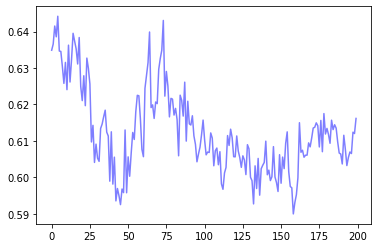

In [20]:

plt.plot(full_footprint_1[0][400:600], label="background", c = "b", alpha=0.5)
plt.plot(runx_footprint[0][400:600], label="AP1-only", c = "orange", alpha=0.8)
plt.plot(irf1_footprint[0][400:600], label="TEAD-only", c = "green", alpha=0.8)
plt.plot(puu_runx_footprint[0][400:600], label="API+TEAD", c = "red")

plt.ylim((0,3.0))
plt.legend()
plt.show()

In [ ]:

plt.plot(full_footprint_1[0], label="background", c = "b", alpha=0.5)
plt.plot(runx_footprint[0], label="AP1-only", c = "orange", alpha=0.8)
plt.plot(irf1_footprint[0], label="TEAD-only", c = "green", alpha=0.8)
plt.plot(puu_runx_footprint[0], label="AP1+TEAD", c = "red")

plt.ylim((0,3.0))
plt.legend()
plt.show()

In [ ]:
print(full_footprint_1[1])
print(runx_footprint[1]-full_footprint_1[1])
print(irf1_footprint[1]-full_footprint_1[1])
print(puu_runx_footprint[1]-full_footprint_1[1])


In [ ]:
plt.plot(full_footprint_1[0], label="background", c = "b", alpha=0.5)
plt.plot(runx_footprint[0], label="RUNX-only", c = "orange", alpha=0.5)
plt.plot(irf1_footprint[0], label="NFYB-only", c = "green", alpha=0.5)
plt.plot(puu_runx_footprint[0], label="NFYB+RUNX", c = "red")

plt.ylim((0,2))
plt.legend()
plt.show()

In [ ]:
plt.plot(full_footprint_1[0][400:600], label="background", c = "b", alpha=0.5)
plt.plot(runx_footprint[0][400:600], label="RUNX-only", c = "orange", alpha=0.8)
plt.plot(irf1_footprint[0][400:600], label="IRF1-only", c = "green", alpha=0.8)
plt.plot(puu_runx_footprint[0][400:600], label="IRF1+RUNX", c = "red")

plt.ylim((0,2))
plt.legend(loc="upper left")
plt.show()